In [1]:
import pickle

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import mark_inset, zoomed_inset_axes

In [2]:
tasks = ["twomoons", "gmm", "invkinematics"]
budget = 1024
estimators = ["ac", "nsf", "cmpe", "fmpe"]

sampling_steps = [2, 5, 7, 8, 10, 20, 30, 40, 50, 100]

In [3]:
colors = ["#4477AA", "#EE6677", "#228833", "#CCBB44", "#66CCEE", "#AA3377", "#BBBBBB"]

plot_settings = {
    "ac": {"name": "ACF", "color": colors[0]},
    "nsf": {"name": "NSF", "color": colors[1]},
    "fmpe": {"name": "FMPE", "color": colors[5]},
    "fmpe10": {"name": "FMPE 10#", "color": colors[2]},
    "fmpe30": {"name": "FMPE 30#", "color": colors[4]},
    "cmpe": {"name": "CMPE (Ours)", "color": colors[3]},
    "cmpe10": {"name": "CMPE 10#", "color": colors[3]},
    "cmpe30": {"name": "CMPE 30#", "color": colors[6]},
}

In [4]:
eval_dict = pickle.load(open("./computations/eval_dict_speed_performance_ik.pkl", "rb"))

/var/folders/8n/pc0r4zbs3pn15xp3s0d7hk6h0000gn/T/ipykernel_17457/3658602096.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  f.tight_layout()


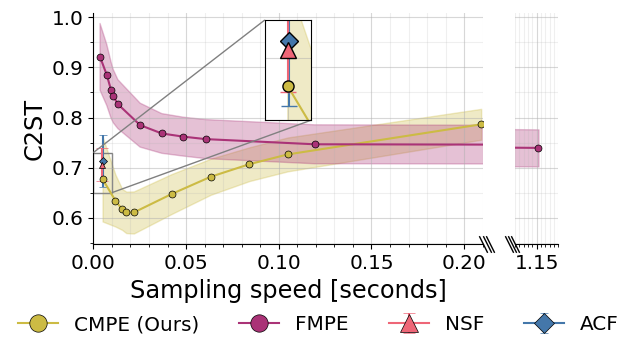

In [5]:
point_kws = {
    "nsf": dict(marker="^", markersize=5, capsize=4, markeredgewidth=0.5, markeredgecolor="black"),
    "ac": dict(marker="D", markersize=4, capsize=3, markeredgewidth=0.5, markeredgecolor="black"),
    "fmpe": dict(marker="V", markersize=5, markeredgecolor="black", markeredgewidth=0.5, capsize=4),
}


line_kws = dict(marker="o", linestyle="-", markeredgecolor="black", markeredgewidth=0.5, markersize=5)

n_test_samples = eval_dict["gmm"]["ac"]["posterior_samples"].shape[0] * 4  # (hack to get speed per 1000 samples)


# less space between subplots
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3), sharey=True, width_ratios=(0.90, 0.10), gridspec_kw={"wspace": 0.15})
task = "gmm"
for ax in (ax1, ax2):
    # AC and NSF -> single point with error bars
    for estimator in ["ac", "nsf"]:
        c2st_mean = np.mean(eval_dict[task][estimator]["c2st"])
        c2st_std = np.std(eval_dict[task][estimator]["c2st"]) / np.sqrt(1)
        ax.errorbar(
            eval_dict[task][estimator]["time"] / n_test_samples,
            c2st_mean,
            yerr=c2st_std,
            label=plot_settings[estimator]["name"],
            color=plot_settings[estimator]["color"],
            **point_kws[estimator],
        )

    # CMPE: line with error bars
    cmpe_times = [eval_dict[task][f"cmpe{step}"]["time"] / n_test_samples for step in sampling_steps]
    cmpe_c2st = [np.mean(eval_dict[task][f"cmpe{step}"]["c2st"]) for step in sampling_steps]
    cmpe_std = [np.std(eval_dict[task][f"cmpe{step}"]["c2st"]) for step in sampling_steps]
    ax.plot(cmpe_times, cmpe_c2st, label="CMPE (Ours)", color=plot_settings["cmpe"]["color"], **line_kws)
    ax.fill_between(
        cmpe_times,
        np.array(cmpe_c2st) - np.array(cmpe_std) / np.sqrt(1),
        np.array(cmpe_c2st) + np.array(cmpe_std) / np.sqrt(1),
        alpha=0.3,
        color=plot_settings["cmpe"]["color"],
    )

    # FMPE: Line and point with error bars
    c2st_mean = np.mean(eval_dict[task]["fmpe"]["c2st"])
    c2st_std = np.std(eval_dict[task]["fmpe"]["c2st"])
    # ax.scatter(eval_dict[task]['fmpe']['time']/n_test_samples, c2st_mean, label='FMPE', color=plot_settings['fmpe']['color'], **point_kws['fmpe'])

    fmpe_times = [eval_dict[task][f"fmpe{step}"]["time"] / n_test_samples for step in sampling_steps] + [
        eval_dict[task]["fmpe"]["time"] / n_test_samples
    ]
    fmpe_c2st = [np.mean(eval_dict[task][f"fmpe{step}"]["c2st"]) for step in sampling_steps] + [
        np.mean(eval_dict[task]["fmpe"]["c2st"])
    ]
    fmpe_std = [np.std(eval_dict[task][f"fmpe{step}"]["c2st"]) for step in sampling_steps] + [
        np.std(eval_dict[task]["fmpe"]["c2st"])
    ]
    ax.plot(fmpe_times, fmpe_c2st, label="FMPE", color=plot_settings["fmpe"]["color"], **line_kws)
    ax.fill_between(
        fmpe_times,
        np.array(fmpe_c2st) - np.array(fmpe_std) / np.sqrt(1),
        np.array(fmpe_c2st) + np.array(fmpe_std) / np.sqrt(1),
        alpha=0.3,
        color=plot_settings["fmpe"]["color"],
    )

    ax.set_ylim(None, None)
    # ax.set_title(task)
    # log x axis
    # ax.set_xscale('log')
    # x labels as decimals
    # ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.16g}'.format(x)))
    # larger tick labels
    ax.tick_params(axis="both", which="major", labelsize="x-large")
    # minor grid every 0.01 units in y and x
    ax.xaxis.set_major_locator(plt.MultipleLocator(0.05))
    ax.xaxis.set_minor_locator(plt.MultipleLocator(0.01))
    ax.yaxis.set_minor_locator(plt.MultipleLocator(0.05))
    # 0.01 grid
    ax.grid(which="minor", alpha=0.2, zorder=-1)
    # 0.1 grid
    ax.grid(which="major", alpha=0.5, zorder=-1)
    ax.set_xlim(0, 1.0)
    ax.grid(zorder=-1, alpha=0.5)
    sns.despine(ax=ax)


# add a zoom-in to the plot
# between top center and top right
axins = zoomed_inset_axes(ax1, 2.5, loc="upper center", bbox_to_anchor=(0.5, 1.0), bbox_transform=ax1.transAxes)
# show zoom-in
axins.errorbar(
    eval_dict[task]["ac"]["time"] / n_test_samples,
    np.mean(eval_dict[task]["ac"]["c2st"]),
    yerr=np.std(eval_dict[task]["ac"]["c2st"]) / np.sqrt(1),
    label="ACF",
    color=plot_settings["ac"]["color"],
    markersize=9,
    marker="D",
    capsize=6,
    markeredgecolor="black",
)
axins.errorbar(
    eval_dict[task]["nsf"]["time"] / n_test_samples,
    np.mean(eval_dict[task]["nsf"]["c2st"]),
    yerr=np.std(eval_dict[task]["nsf"]["c2st"]) / np.sqrt(1),
    label="NSF",
    color=plot_settings["nsf"]["color"],
    markersize=12,
    marker="^",
    capsize=6,
    markeredgecolor="black",
)
axins.plot(
    cmpe_times,
    cmpe_c2st,
    label="CMPE (Ours)",
    color=plot_settings["cmpe"]["color"],
    marker="o",
    linestyle="-",
    markersize=8,
    markeredgecolor="black",
)
axins.plot(
    fmpe_times, fmpe_c2st, label="FMPE", color=plot_settings["fmpe"]["color"], marker="o", linestyle="-", markersize=8
)
axins.fill_between(
    cmpe_times,
    np.array(cmpe_c2st) - np.array(cmpe_std) / np.sqrt(1),
    np.array(cmpe_c2st) + np.array(cmpe_std) / np.sqrt(1),
    alpha=0.3,
    color=plot_settings["cmpe"]["color"],
)

# add grid to inset axis
axins.grid(zorder=-1, alpha=0.5)

# sub region of the original image
x1, x2, y1, y2 = 0.00, 0.01, 0.68, 0.73
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_xticks([0.005])
axins.set_yticks([0.65, 0.70])
# 0.01 grid
axins.grid(which="minor", alpha=0.2, zorder=-1)
axins.set_xticklabels([])
axins.set_yticklabels([])
axins.tick_params(axis="both", which="both", length=0)
axins.grid(zorder=-1, alpha=0.5)
mark_inset(ax1, axins, loc1=4, loc2=2, fc="none", ec="0.5")

ax1.set_xlim(0, 0.21)
ax2.set_xlim(1.1, 1.2)
ax1.set_xlabel("Sampling speed [seconds]", fontsize="xx-large")
ax1.set_ylabel("C2ST", fontsize="xx-large")

ax1.spines["right"].set_visible(False)
ax2.spines["left"].set_visible(False)
# ax2.spines['top'].set_visible(False)
# ax.yaxis.tick_left()
# ax.tick_params(labeltop='off') # don't put tick labels at the top
# ax2.yaxis.tick_right()
ax2.set_xticks([1.15])
ax2.tick_params(axis="y", which="both", length=0)

d = 0.5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-d, 1), (d, -1)], markersize=12, linestyle="none", color="k", mec="k", mew=1, clip_on=False)
ax1.plot([1, 1.01, 1.02], [0, 0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([-0.15, -0.08, 0], [0, 0, 0], transform=ax2.transAxes, **kwargs)


lines, labels = ax1.get_legend_handles_labels()
lines = [lines[0], lines[1], lines[3], lines[2]]
labels = [labels[0], labels[1], labels[3], labels[2]]
# legend below plot with 1 row
f.legend(
    lines,
    labels,
    loc="lower center",
    ncol=4,
    bbox_to_anchor=(0.5, -0.25),
    fontsize="x-large",
    frameon=False,
    markerscale=2.5,
)
f.tight_layout()
f.savefig("./figures/speed_performance_c2st_gmm.pdf", bbox_inches="tight")

/var/folders/8n/pc0r4zbs3pn15xp3s0d7hk6h0000gn/T/ipykernel_17457/977356485.py:120: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  f.tight_layout()


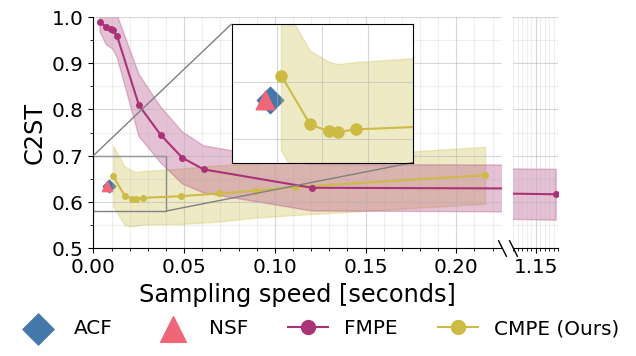

In [6]:
point_kws = {
    "nsf": dict(marker="^", s=55),
    "ac": dict(marker="D", s=40),
    "fmpe": dict(marker="V", s=55),
}


line_kws = dict(marker="o", linestyle="-", markersize=4)

n_test_samples = eval_dict["twomoons"]["ac"]["posterior_samples"].shape[0] * 4


# less space between subplots
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3), sharey=True, width_ratios=(0.90, 0.10), gridspec_kw={"wspace": 0.05})
task = "twomoons"
for ax in (ax1, ax2):
    # AC and NSF -> single point with error bars
    for estimator in ["ac", "nsf"]:
        c2st_mean = np.mean(eval_dict[task][estimator]["c2st"])
        c2st_std = np.std(eval_dict[task][estimator]["c2st"]) / np.sqrt(1)
        ax.scatter(
            eval_dict[task][estimator]["time"] / n_test_samples,
            c2st_mean,
            label=plot_settings[estimator]["name"],
            color=plot_settings[estimator]["color"],
            **point_kws[estimator],
        )

    # CMPE: line with error bars
    cmpe_times = [eval_dict[task][f"cmpe{step}"]["time"] / n_test_samples for step in sampling_steps]
    cmpe_c2st = [np.mean(eval_dict[task][f"cmpe{step}"]["c2st"]) for step in sampling_steps]
    cmpe_std = [np.std(eval_dict[task][f"cmpe{step}"]["c2st"]) for step in sampling_steps]
    ax.plot(cmpe_times, cmpe_c2st, label="CMPE (Ours)", color=plot_settings["cmpe"]["color"], **line_kws)
    ax.fill_between(
        cmpe_times,
        np.array(cmpe_c2st) - np.array(cmpe_std) / np.sqrt(1),
        np.array(cmpe_c2st) + np.array(cmpe_std) / np.sqrt(1),
        alpha=0.3,
        color=plot_settings["cmpe"]["color"],
    )

    # FMPE: Line and point with error bars
    c2st_mean = np.mean(eval_dict[task]["fmpe"]["c2st"])
    c2st_std = np.std(eval_dict[task]["fmpe"]["c2st"])
    # ax.scatter(eval_dict[task]['fmpe']['time']/n_test_samples, c2st_mean, label='FMPE', color=plot_settings['fmpe']['color'], **point_kws['fmpe'])

    fmpe_times = [eval_dict[task][f"fmpe{step}"]["time"] / n_test_samples for step in sampling_steps] + [
        eval_dict[task]["fmpe"]["time"] / n_test_samples
    ]
    fmpe_c2st = [np.mean(eval_dict[task][f"fmpe{step}"]["c2st"]) for step in sampling_steps] + [
        np.mean(eval_dict[task]["fmpe"]["c2st"])
    ]
    fmpe_std = [np.std(eval_dict[task][f"fmpe{step}"]["c2st"]) for step in sampling_steps] + [
        np.std(eval_dict[task]["fmpe"]["c2st"])
    ]
    ax.plot(fmpe_times, fmpe_c2st, label="FMPE", color=plot_settings["fmpe"]["color"], **line_kws)
    ax.fill_between(
        fmpe_times,
        np.array(fmpe_c2st) - np.array(fmpe_std) / np.sqrt(1),
        np.array(fmpe_c2st) + np.array(fmpe_std) / np.sqrt(1),
        alpha=0.3,
        color=plot_settings["fmpe"]["color"],
    )

    ax.set_ylim(0.50, 1.0)
    # ax.set_title(task)
    # log x axis
    # ax.set_xscale('log')
    # x labels as decimals
    # ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.16g}'.format(x)))
    # larger tick labels
    ax.tick_params(axis="both", which="major", labelsize="x-large")
    # minor grid every 0.01 units in y and x
    ax.xaxis.set_major_locator(plt.MultipleLocator(0.05))
    ax.xaxis.set_minor_locator(plt.MultipleLocator(0.01))
    ax.yaxis.set_minor_locator(plt.MultipleLocator(0.05))
    # 0.01 grid
    ax.grid(which="minor", alpha=0.2, zorder=-1)
    # 0.1 grid
    ax.grid(which="major", alpha=0.5, zorder=-1)
    ax.set_xlim(0, 1.0)
    ax.grid(zorder=-1, alpha=0.5)
    sns.despine(ax=ax)


# add a zoom-in to the plot
# between top center and top right
axins = zoomed_inset_axes(ax1, 2.5, loc="upper right", bbox_to_anchor=(0.8, 1.0), bbox_transform=ax1.transAxes)
# show zoom-in
axins.scatter(
    eval_dict[task]["ac"]["time"] / n_test_samples,
    np.mean(eval_dict[task]["ac"]["c2st"]),
    label="ACF",
    color=plot_settings["ac"]["color"],
    s=180,
    marker="D",
)
axins.scatter(
    eval_dict[task]["nsf"]["time"] / n_test_samples,
    np.mean(eval_dict[task]["nsf"]["c2st"]),
    label="NSF",
    color=plot_settings["nsf"]["color"],
    s=180,
    marker="^",
)
axins.plot(
    cmpe_times,
    cmpe_c2st,
    label="CMPE (Ours)",
    color=plot_settings["cmpe"]["color"],
    marker="o",
    linestyle="-",
    markersize=8,
)
axins.plot(
    fmpe_times, fmpe_c2st, label="FMPE", color=plot_settings["fmpe"]["color"], marker="o", linestyle="-", markersize=8
)
axins.fill_between(
    cmpe_times,
    np.array(cmpe_c2st) - np.array(cmpe_std) / np.sqrt(1),
    np.array(cmpe_c2st) + np.array(cmpe_std) / np.sqrt(1),
    alpha=0.3,
    color=plot_settings["cmpe"]["color"],
)

# add grid to inset axis
axins.grid(zorder=-1, alpha=0.5)

# sub region of the original image
x1, x2, y1, y2 = 0.00, 0.04, 0.58, 0.7
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_xticks([0.01, 0.02, 0.03])
axins.set_yticks([0.60, 0.65])
# 0.01 grid
axins.grid(which="minor", alpha=0.2, zorder=-1)
axins.set_xticklabels([])
axins.set_yticklabels([])
axins.tick_params(axis="both", which="both", length=0)
axins.grid(zorder=-1, alpha=0.5)
mark_inset(ax1, axins, loc1=4, loc2=2, fc="none", ec="0.5")

ax1.set_xlim(0, 0.9 / 4)
ax2.set_xlim(1.1, 1.2)
ax1.set_xlabel("Sampling speed [seconds]", fontsize="xx-large")
ax1.set_ylabel("C2ST", fontsize="xx-large")

ax1.spines["right"].set_visible(False)
ax2.spines["left"].set_visible(False)
# ax2.spines['top'].set_visible(False)
# ax.yaxis.tick_left()
# ax.tick_params(labeltop='off') # don't put tick labels at the top
# ax2.yaxis.tick_right()
ax2.set_xticks([1.15])
ax2.tick_params(axis="y", which="both", length=0)

d = 0.5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-d, 1), (d, -1)], markersize=12, linestyle="none", color="k", mec="k", mew=1, clip_on=False)
ax1.plot(1, 0, transform=ax1.transAxes, **kwargs)
ax2.plot(0, 0, transform=ax2.transAxes, **kwargs)

lines, labels = ax1.get_legend_handles_labels()
lines = [lines[0], lines[1], lines[3], lines[2]]
labels = [labels[0], labels[1], labels[3], labels[2]]
# legend below plot with 1 row
f.legend(
    lines,
    labels,
    loc="lower center",
    ncol=4,
    bbox_to_anchor=(0.5, -0.25),
    fontsize="x-large",
    frameon=False,
    markerscale=2.5,
)
f.tight_layout()
f.savefig("./figures/speed_performance_c2st_twomoons.pdf", bbox_inches="tight")

In [ ]:
# TODO: Repeat this with correct reference samples

point_kws = {
    "nsf": dict(marker="^", s=55),
    "ac": dict(marker="D", s=40),
    "fmpe": dict(marker="V", s=55),
}


line_kws = dict(marker="o", linestyle="-", markersize=4)

n_test_samples = eval_dict["twomoons"]["ac"]["posterior_samples"].shape[0] * 4


# less space between subplots
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3), sharey=True, width_ratios=(0.90, 0.10), gridspec_kw={"wspace": 0.05})
task = "invkinematics"
for ax in (ax1, ax2):
    # AC and NSF -> single point with error bars
    for estimator in ["ac", "nsf"]:
        c2st_mean = np.mean(eval_dict[task][estimator]["c2st"])
        c2st_std = np.std(eval_dict[task][estimator]["c2st"]) / np.sqrt(1)
        ax.scatter(
            eval_dict[task][estimator]["time"] / n_test_samples,
            c2st_mean,
            label=plot_settings[estimator]["name"],
            color=plot_settings[estimator]["color"],
            **point_kws[estimator],
        )

    # CMPE: line with error bars
    cmpe_times = [eval_dict[task][f"cmpe{step}"]["time"] / n_test_samples for step in sampling_steps]
    cmpe_c2st = [np.mean(eval_dict[task][f"cmpe{step}"]["c2st"]) for step in sampling_steps]
    cmpe_std = [np.std(eval_dict[task][f"cmpe{step}"]["c2st"]) for step in sampling_steps]
    ax.plot(cmpe_times, cmpe_c2st, label="CMPE (Ours)", color=plot_settings["cmpe"]["color"], **line_kws)
    ax.fill_between(
        cmpe_times,
        np.array(cmpe_c2st) - np.array(cmpe_std) / np.sqrt(1),
        np.array(cmpe_c2st) + np.array(cmpe_std) / np.sqrt(1),
        alpha=0.3,
        color=plot_settings["cmpe"]["color"],
    )

    # FMPE: Line and point with error bars
    c2st_mean = np.mean(eval_dict[task]["fmpe"]["c2st"])
    c2st_std = np.std(eval_dict[task]["fmpe"]["c2st"])
    # ax.scatter(eval_dict[task]['fmpe']['time']/n_test_samples, c2st_mean, label='FMPE', color=plot_settings['fmpe']['color'], **point_kws['fmpe'])

    fmpe_times = [eval_dict[task][f"fmpe{step}"]["time"] / n_test_samples for step in sampling_steps] + [
        eval_dict[task]["fmpe"]["time"] / n_test_samples
    ]
    fmpe_c2st = [np.mean(eval_dict[task][f"fmpe{step}"]["c2st"]) for step in sampling_steps] + [
        np.mean(eval_dict[task]["fmpe"]["c2st"])
    ]
    fmpe_std = [np.std(eval_dict[task][f"fmpe{step}"]["c2st"]) for step in sampling_steps] + [
        np.std(eval_dict[task]["fmpe"]["c2st"])
    ]
    ax.plot(fmpe_times, fmpe_c2st, label="FMPE", color=plot_settings["fmpe"]["color"], **line_kws)
    ax.fill_between(
        fmpe_times,
        np.array(fmpe_c2st) - np.array(fmpe_std) / np.sqrt(1),
        np.array(fmpe_c2st) + np.array(fmpe_std) / np.sqrt(1),
        alpha=0.3,
        color=plot_settings["fmpe"]["color"],
    )

    ax.set_ylim(None, None)
    # ax.set_title(task)
    # log x axis
    # ax.set_xscale('log')
    # x labels as decimals
    # ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.16g}'.format(x)))
    # larger tick labels
    ax.tick_params(axis="both", which="major", labelsize="x-large")
    # minor grid every 0.01 units in y and x
    ax.xaxis.set_major_locator(plt.MultipleLocator(0.05))
    ax.xaxis.set_minor_locator(plt.MultipleLocator(0.01))
    ax.yaxis.set_minor_locator(plt.MultipleLocator(0.05))
    # 0.01 grid
    ax.grid(which="minor", alpha=0.2, zorder=-1)
    # 0.1 grid
    ax.grid(which="major", alpha=0.5, zorder=-1)
    ax.set_xlim(0, 1.0)
    ax.grid(zorder=-1, alpha=0.5)
    sns.despine(ax=ax)


# add a zoom-in to the plot
# between top center and top right
axins = zoomed_inset_axes(ax1, 2.5, loc="upper right", bbox_to_anchor=(0.8, 1.0), bbox_transform=ax1.transAxes)
# show zoom-in
axins.scatter(
    eval_dict[task]["ac"]["time"] / n_test_samples,
    np.mean(eval_dict[task]["ac"]["c2st"]),
    label="ACF",
    color=plot_settings["ac"]["color"],
    s=180,
    marker="D",
)
axins.scatter(
    eval_dict[task]["nsf"]["time"] / n_test_samples,
    np.mean(eval_dict[task]["nsf"]["c2st"]),
    label="NSF",
    color=plot_settings["nsf"]["color"],
    s=180,
    marker="^",
)
axins.plot(
    cmpe_times,
    cmpe_c2st,
    label="CMPE (Ours)",
    color=plot_settings["cmpe"]["color"],
    marker="o",
    linestyle="-",
    markersize=8,
)
axins.plot(
    fmpe_times, fmpe_c2st, label="FMPE", color=plot_settings["fmpe"]["color"], marker="o", linestyle="-", markersize=8
)
axins.fill_between(
    cmpe_times,
    np.array(cmpe_c2st) - np.array(cmpe_std) / np.sqrt(1),
    np.array(cmpe_c2st) + np.array(cmpe_std) / np.sqrt(1),
    alpha=0.3,
    color=plot_settings["cmpe"]["color"],
)

# add grid to inset axis
axins.grid(zorder=-1, alpha=0.5)

# sub region of the original image
x1, x2, y1, y2 = 0.00, 0.04, 0.7, 0.75
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_xticks([0.01, 0.02, 0.03])
axins.set_yticks([0.69, 0.75])
# 0.01 grid
axins.grid(which="minor", alpha=0.2, zorder=-1)
axins.set_xticklabels([])
axins.set_yticklabels([])
axins.tick_params(axis="both", which="both", length=0)
axins.grid(zorder=-1, alpha=0.5)
mark_inset(ax1, axins, loc1=4, loc2=2, fc="none", ec="0.5")

ax1.set_xlim(0, 0.9 / 4)
ax2.set_xlim(1.1, 1.2)
ax1.set_xlabel("Sampling speed [seconds]", fontsize="xx-large")
ax1.set_ylabel("C2ST", fontsize="xx-large")

ax1.spines["right"].set_visible(False)
ax2.spines["left"].set_visible(False)
# ax2.spines['top'].set_visible(False)
# ax.yaxis.tick_left()
# ax.tick_params(labeltop='off') # don't put tick labels at the top
# ax2.yaxis.tick_right()
ax2.set_xticks([1.15])
ax2.tick_params(axis="y", which="both", length=0)

d = 0.5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-d, 1), (d, -1)], markersize=12, linestyle="none", color="k", mec="k", mew=1, clip_on=False)
ax1.plot(1, 0, transform=ax1.transAxes, **kwargs)
ax2.plot(0, 0, transform=ax2.transAxes, **kwargs)

lines, labels = ax1.get_legend_handles_labels()
lines = [lines[0], lines[1], lines[3], lines[2]]
labels = [labels[0], labels[1], labels[3], labels[2]]
# legend below plot with 1 row
f.legend(
    lines,
    labels,
    loc="lower center",
    ncol=4,
    bbox_to_anchor=(0.5, -0.25),
    fontsize="x-large",
    frameon=False,
    markerscale=2.5,
)
f.tight_layout()
f.savefig("./figures/speed_performance_c2st_twomoons.pdf", bbox_inches="tight")